# Fuel Pin (3D): Heat Conduction
This notebook presents the heat conduction in a fuel pin of PWR, consisting of different regions: fuel, gap and cladding. The heat conduction is modeled by the heat equation, which is a partial differential equation (PDE) that describes the distribution of heat (or variation in temperature) in a given region over time. The heat equation is given by:
\begin{equation*}
\nabla \cdot (k \nabla T) + q'''=0
\end{equation*}
where $T$ is the temperature, $t$ is the time, $k$ is the thermal conductivity, and $q$ is the heat source. The heat equation is solved numerically using the finite elemennt method (FEM) in a 3D domain. The problem is closed by suitable boundary conditions, accounting for the heat transfer at the boundaries of the domain. The heat source is user-defined.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm

import gmsh

The `constants.py` file contains the important parameters for this tutorial, including the variable `n_div` which describes how many divisions are made in the fuel pin.

In [2]:
from constants import *
print('The number of axial divisions is '+ str(n_div))

The number of axial divisions is 8


## Create gmsh geometry
In this section, the geometry of the fuel pin is created using the Gmsh Python API.

In [21]:
vol_markers = [3000,2000,1000] # markers defining the volumes (fuel, clad, gap)
surf_markers = [100, 200, 300] # marker for the heat transfer surface (coolant_interface, bot, top)

# center_x = 0
# center_y = 0
base_z = -l_active/2

In this cell, the mesh is created using GMSH API (not entering into details).

The `mesh_factor` defines the mesh refinement.

In [ ]:
mesh_factor = 0.0015

if os.path.exists("../mesh/cyl3D.msh") == False:

    # Initialize the gmsh module
    gmsh.initialize()

    # Load the .geo file
    gmsh.merge('../mesh/cyl3D.geo')
    gmsh.model.geo.synchronize()

    # Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
    gmsh.option.setNumber("Mesh.Algorithm", 6)

    if mesh_factor is not None:
        gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)

    gmsh.model.mesh.generate(1)
    gmsh.model.mesh.generate(2)
    gmsh.model.mesh.generate(3)

    gmsh.option.setNumber("Mesh.MshFileVersion", 2) #save in ASCII 2 format
    

    # Save the mesh
    gmsh.write("../mesh/cyl3D.msh")
    # gmsh.write("cyl3D.vtk")

else:
    gmsh.initialize()
    gmsh.merge("../mesh/cyl3D.msh")

Info    : Reading 'cyl3D.geo'...
Info    : Done reading 'cyl3D.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 10%] Meshing curve 2 (Circle)
Info    : [ 10%] Meshing curve 3 (Circle)
Info    : [ 20%] Meshing curve 4 (Extruded)
Info    : [ 20%] Meshing curve 5 (Extruded)
Info    : [ 30%] Meshing curve 6 (Extruded)
Info    : [ 30%] Meshing curve 7 (Extruded)
Info    : [ 40%] Meshing curve 8 (Extruded)
Info    : [ 40%] Meshing curve 9 (Extruded)
Info    : [ 50%] Meshing curve 10 (Extruded)
Info    : [ 50%] Meshing curve 11 (Extruded)
Info    : [ 60%] Meshing curve 12 (Extruded)
Info    : [ 60%] Meshing curve 13 (Extruded)
Info    : [ 70%] Meshing curve 14 (Extruded)
Info    : [ 70%] Meshing curve 15 (Extruded)
Info    : [ 80%] Meshing curve 16 (Extruded)
Info    : [ 80%] Meshing curve 17 (Extruded)
Info    : [ 90%] Meshing curve 18 (Extruded)
Info    : [ 90%] Meshing curve 19 (Extruded)
Info    : [100%] Meshing curve 20 (Extruded)
Info    : [100%] Meshin

Info    : Meshing 3D...
Info    : Meshing volume 1 (Extruded)
Info    : Meshing volume 2 (Extruded)
Info    : Meshing volume 3 (Extruded)
Info    : Meshing volume 4 (Extruded)
Info    : Meshing volume 5 (Extruded)
Info    : Meshing volume 6 (Extruded)
Info    : Meshing volume 7 (Extruded)
Info    : Meshing volume 8 (Extruded)
Info    : Meshing volume 9 (Extruded)
Info    : Subdividing extruded mesh
Info    : Swapping 2982
Info    : Swapping 0
Info    : Remeshing surface 4
Info    : Meshing surface 4 (Extruded)
Info    : Remeshing surface 5
Info    : Meshing surface 5 (Extruded)
Info    : Remeshing surface 7
Info    : Meshing surface 7 (Extruded)
Info    : Remeshing surface 10
Info    : Meshing surface 10 (Extruded)
Info    : Remeshing surface 12
Info    : Meshing surface 12 (Extruded)
Info    : Remeshing surface 14
Info    : Meshing surface 14 (Extruded)
Info    : Remeshing surface 16
Info    : Meshing surface 16 (Extruded)
Info    : Remeshing surface 18
Info    : Meshing surface 18 (E

Let us create the geometry in *dolfinx* from the gmsh variable

In [6]:
from dolfinx.io import gmshio
from mpi4py import MPI

mesh_comm = MPI.COMM_WORLD
gdim = 3
model_rank = 0 

domain, ct, ft = gmshio.model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )

gmsh.finalize()

## Set up the thermal solver
In this section, the thermal solver is set up. The solver is based on the finite element method (FEM) and uses the `dolfinx` library.

In [7]:
import sys
sys.path.append('../')

from thermal import thermal_inputs, robin_class, thermal_solver, dirichlet_class

th_input = thermal_inputs(T_w_average, pressure)

# The thermal conducticity of the helium gap is increased to consider the radiation HT
physical_param = {'th_cond': np.array([3, 0.25 * 3, 16.23]) / 100.}

T_b_fun = lambda x: Tin + (Tout - Tin)/2*(1+np.sin((x[2])/l_active*np.pi))

bcs =[
      robin_class(marker = surf_markers[0], h = th_input.compute_htc(pitch, clad_or,u_in), Tb = T_b_fun),
      # dirichlet_class(1000, surf_markers[0]),
      # dirichlet_class(Tin, surf_markers[1]),
      # dirichlet_class(Tout, surf_markers[2])
      ]

Let us plot the bulk temperature of the coolant

Text(0, 0.5, 'Coolant Temperature (K)')

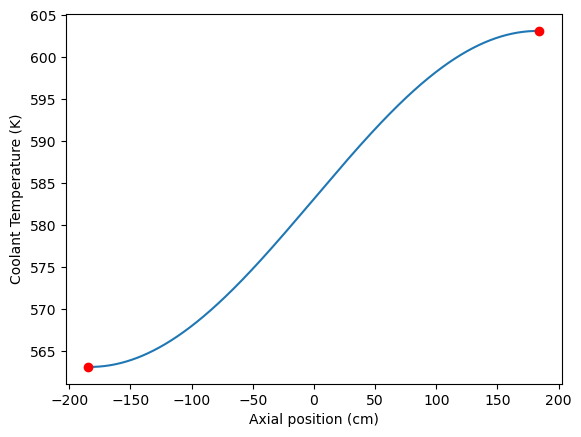

In [8]:
z = np.zeros((1000,3)).T
z[2] = np.linspace(domain.geometry.x[:,2].min(), domain.geometry.x[:,2].max(), z.shape[-1])

plt.plot(z[2], T_b_fun(z))
plt.plot(z[2,0], Tin, 'ro')
plt.plot(z[2,-1], Tout, 'ro')

plt.xlabel('Axial position (cm)')
plt.ylabel('Coolant Temperature (K)')

Let us define the thermal solver with P1 elements

In [9]:
TH = thermal_solver(domain = domain, ct = ct, ft = ft,
                    physical_param = physical_param, regions_markers = vol_markers,
                    degree=1)

The method `apply_BC` applies the boundary conditions to the problem, whereas the method `assemble` assembles the linear system of equations.

In [ ]:
TH.applyBCs(bcs)
TH.assemble(direct=False)

Let us define the power density in the fuel pin. The power density is defined as a function of $\mathbf{x}$
\begin{equation*}
q'''(\mathbf{x}) = P\cdot \cos\left(\frac{\pi\,z}{L_{active}}\right)
\end{equation*}
where $P$ is the normalisation constant, $L_{active}$ is the active length of the fuel pin and $\mathbf{x}=[x,y,z]$.

Text(0, 0.5, 'Normalised Power (-)')

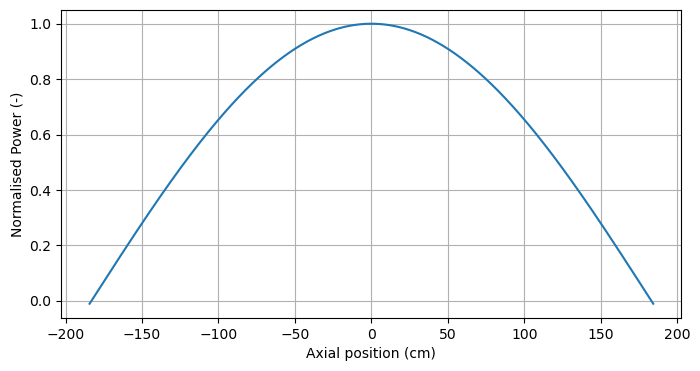

In [20]:
power_funs = [lambda x: 0. + 0.*x[0] + 0.*x[1] + np.cos(x[2]/l_active*np.pi), lambda x: 0. + 0.*x[0] + 0.*x[1], lambda x: 0. + 0.*x[0] + 0.*x[1]]

fig = plt.figure(figsize=(8,4))
plt.plot(z[2], power_funs[0](z))
plt.grid()
plt.xlabel('Axial position (cm)')
plt.ylabel('Normalised Power (-)')

## Run the thermal simulation
An iterative linear solver is used to solve the discretised heat equation.

This method takes the `power_funs` as input and the Power to normalize the total power to it and returns the temperature and the power density in the domain.

In [12]:
Power = 65e3# W 
T_sol, q_sol = TH.solve(power_funs, Power)

## Post Processing the solution
In this section, the solution is post-processed using `pyvista` and `matplotlib`.

The function `grid` is used to create the 3D grid for pyvista taken from [pyforce](https://github.com/ERMETE-Lab/ROSE-pyforce/blob/main/pyforce/pyforce/tools/plotting.py).

In [13]:
import pyvista as pv
import dolfinx

# If run on ssh 
pv.start_xvfb()

def grids(fun: dolfinx.fem.Function, varname='u', log_plot: bool = False, 
          mag_plot: bool = True, **kwargs):
    """
    Creates a PyVista grid from a dolfinx.fem.Function and returns the warped or glyph representation.
    
    Parameters
    ----------
    fun : `dolfinx.fem.Function` 
        The function representing the field to be visualized.
    varname : str
        The name to assign to the data in the PyVista grid (default is 'u').
    log_plot : bool
        If True, apply a logarithmic plot to scalar data (default is False).
    mag_plot : bool
        If True, creates a vector warp of the grid. If False, uses glyphs (default is True).
    **kwargs
        Additional keyword arguments passed to the function.
    
    Returns
    ----------
    grid : `pyvista.UnstructuredGrid`
        The resulting PyVista grid, which can be visualized using PyVista plotting functions.
    
    """
    
    # Create a VTK mesh from the function's function space
    topology, cells, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    grid = pv.UnstructuredGrid(topology, cells, geometry)
    
    # Handle vector fields (multiple subspaces)
    if fun.function_space.num_sub_spaces > 0:
        # Initialize the values array with zeros and assign the real part of the function's array
        values = np.zeros((geometry.shape[0], 3))
        values[:, :len(fun)] = np.real(fun.x.array.reshape(geometry.shape[0], len(fun)))
        grid[varname] = values

        # Choose between warping by vector or using glyphs
        if mag_plot:
            kwargs.pop('factor', None)  # Remove 'factor' if present, do nothing if not
            kwargs.pop('tolerance', None)  # Remove 'tolerance' if present, do nothing if not
            warped = grid.warp_by_vector(varname, factor=0, **kwargs)  # Apply `kwargs`
        else:
            warped = grid.glyph(varname, **kwargs)  # Apply `kwargs`
        
        return warped, values
    
    # Handle scalar fields (single subspace)
    else:
        if log_plot:
            values = np.log10(np.real(fun.x.array[:]))    
        else:
            values = np.real(fun.x.array[:])
            
        grid.point_data[varname] = values
        grid.set_active_scalars(varname)
        
        return grid, values.reshape(-1,1)


The temperature is plotted using slices

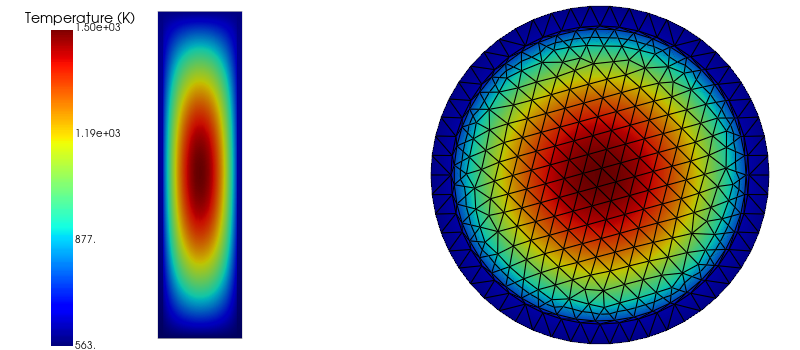

In [14]:
T_grid = grids(T_sol, varname='T', log_plot=False, mag_plot=False)[0]

clim = [min(T_sol.x.array), max(T_sol.x.array)]
cmap = cm.jet

resolution = [800, 350]
pl = pv.Plotter(shape=(1, 2), border=False, window_size=resolution)
    
# Dictionary for the colorbar
dict_cb = dict( title='Temperature (K)',
                width = 0.15, height = 0.95,
                title_font_size=14,
                label_font_size=10,
                n_labels=4,
                color = 'k',
                position_x=0.125, position_y=0.0,
                shadow=False,
                vertical=True) 

pl.subplot(0, 0)

# Scale in the z-direction
matrix_transf = np.eye(4)
matrix_transf[2, 2] = 0.01

pl.add_mesh(T_grid.slice(normal='y').transform(matrix_transf), scalars='T', cmap=cmap, clim=clim, scalar_bar_args=dict_cb)
pl.view_xz()

pl.subplot(0, 1)
pl.add_mesh(T_grid.slice(normal='z'), scalars='T', cmap=cmap, clim=clim, show_edges=True, scalar_bar_args=dict_cb)
pl.view_xy()
pl.zoom_camera(1.4)

pl.show(jupyter_backend='static')


ADD SECTION ON COMPUTE AVERAGE TEMPERATURES

Let us make some plots of the temperature over lines

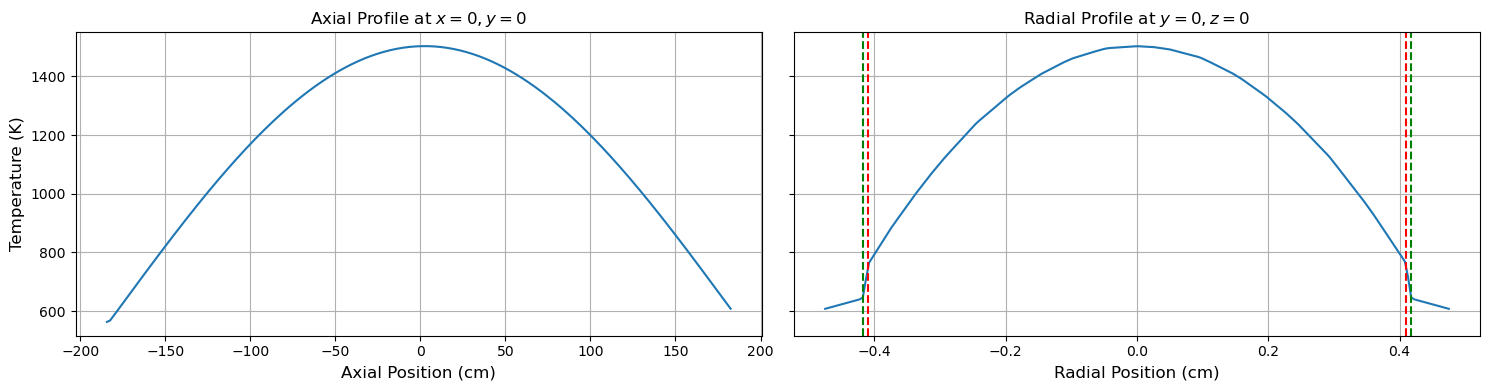

In [15]:
from dolfinx import geometry

def extract_cells(domain: dolfinx.mesh.Mesh, points: np.ndarray):
    """
    This function can be used to extract data along a line defined by the variables `points`, crossing the domain.
 
    Parameters
    ----------
    domain  : dolfinx.mesh.Mesh
        Domain to extract data from.
    points : np.ndarray 
        Points listing the line from which data are extracted.

    Returns
    -------
    xPlot : np.ndarray 
        Coordinate denoting the cell from which data are extracted.
    cells : list
        List of cells of the mesh.
    """
    bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)
    cells = []
    points_on_proc = []
    cell_candidates = geometry.compute_collisions(bb_tree, points.T)
    colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        if len(colliding_cells.links(i))>0:
            points_on_proc.append(point)
            cells.append(colliding_cells.links(i)[0])
    xPlot = np.array(points_on_proc, dtype=np.float64)

    return xPlot, cells

# Axial centerline
axial_ctr_pts = np.zeros((3, 200))
axial_ctr_pts[2] = np.linspace(domain.geometry.x[:,2].min(), domain.geometry.x[:,2].max(), axial_ctr_pts.shape[-1])
xPlot_ax, cells_ax = extract_cells(domain, axial_ctr_pts)

# Radial centerline
radial_ctr_pts = np.zeros((3, 200))
radial_ctr_pts[0] = np.linspace(domain.geometry.x[:,0].min(), domain.geometry.x[:,0].max(), radial_ctr_pts.shape[-1])
xPlot_rad, cells_rad = extract_cells(domain, radial_ctr_pts)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 4))

# Plot along the axial centerline
axs[0].plot(xPlot_ax[:,2], T_sol.eval(xPlot_ax, cells_ax).flatten())
axs[0].set_xlabel('Axial Position (cm)', fontsize=12)
axs[0].set_ylabel('Temperature (K)', fontsize=12)
axs[0].set_title('Axial Profile at $x=0, y=0$', fontsize=12)


axs[1].plot(xPlot_rad[:,0], T_sol.eval(xPlot_rad, cells_rad).flatten())
axs[1].set_xlabel('Radial Position (cm)', fontsize=12)
axs[1].axvline(fuel_or, color='r', linestyle='--', label='Fuel-Clad Interface')
axs[1].axvline(-fuel_or, color='r', linestyle='--', label='Fuel-Clad Interface')
axs[1].axvline(clad_ir, color='g', linestyle='--')
axs[1].axvline(-clad_ir, color='g', linestyle='--')

axs[1].set_title('Radial Profile at $y=0, z=0$', fontsize=12)

for ax in axs:
    ax.grid()

plt.tight_layout()

The power density is plotted using slices

In [16]:
# from dolfinx.fem import Function, Expression
# Q_funP1 = Function(TH.funSpace)
# Q_funP1.interpolate(Expression(q_sol, TH.funSpace.element.interpolation_points()))

# q_grid = grids(Q_funP1, varname='q', log_plot=False, mag_plot=False)[0]

# clim = [min(Q_funP1.x.array), max(Q_funP1.x.array)]
# cmap = cm.viridis

# resolution = [700, 350]
# pl = pv.Plotter(shape=(1, 2), border=False, window_size=resolution)
    
# # Dictionary for the colorbar
# dict_cb['title'] = r'Power density'

# pl.subplot(0, 0)

# # Scale in the z-direction
# matrix_transf = np.eye(4)
# matrix_transf[2, 2] = 0.01

# pl.add_mesh(q_grid.slice(normal='x').transform(matrix_transf), scalars='q', cmap=cmap, clim=clim, scalar_bar_args=dict_cb)
# pl.view_yz()

# pl.subplot(0, 1)
# pl.add_mesh(q_grid.slice(normal='z'), scalars='q', cmap=cmap, clim=clim, show_edges=False, scalar_bar_args=dict_cb)
# pl.view_xy()
# pl.zoom_camera(1.4)

# pl.show(jupyter_backend='static')
